In [74]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
kiwi = Kiwi(model_type='sbg')
from tqdm.auto import tqdm
tqdm.pandas()
import multiprocessing as mp
from functools import partial
from collections import Counter
import re
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import regex as re  # 're' 대신 'regex'를 사용

# 나눔고딕 폰트 경로 설정 (시스템에 따라 경로가 다를 수 있습니다)
font_path = r'C:\Windows\Fonts\NanumGothic.ttf'  # Windows 기준
# font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # Linux 기준
# font_path = '/Library/Fonts/NanumGothic.ttf'  # macOS 기준

# 폰트 프로퍼티 설정
# font_prop = fm.FontProperties(fname=font_path, size=12)
font_prop = fm.FontProperties(size=12)

# 폰트 설정
# plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows의 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

from kiwipiepy import Kiwi
kiwi = Kiwi(model_type='sbg')

In [6]:
ref_df = pd.read_excel('./2008_2022_한국현대문학_인문_복합학_추가데이터_참고문헌_박완서_중복삭제.xlsx')
ref_df

,refebibl-id,type-code,type-name,title,author,journal-name,pubi-year,volume,isseue,serno,...,degree,university,department,artiId,url,citation-day,site-name,registration-day,conference-name,modern_liter
0,REF041663861,3,단행본,역사 속의 페미니스트,거다 러너,NaN,1993,NaN,NaN,NaN,...,NaN,NaN,NaN,ART002094298,NaN,NaN,NaN,NaN,NaN,추가
1,REF041663862,3,단행본,가사집2,고정옥,NaN,1996,NaN,NaN,NaN,...,NaN,NaN,NaN,ART002094298,NaN,NaN,NaN,NaN,NaN,추가
2,REF041663863,3,단행본,가사문학대계,권영철,NaN,1979,NaN,NaN,NaN,...,NaN,NaN,NaN,ART002094298,NaN,NaN,NaN,NaN,NaN,추가
3,REF041663864,3,단행본,규방가사연구,권영철,NaN,1980,NaN,NaN,NaN,...,NaN,NaN,NaN,ART002094298,NaN,NaN,NaN,NaN,NaN,추가
4,REF041663865,3,단행본,注解歌辭文學全集,金聖配,NaN,1979,NaN,NaN,NaN,...,NaN,NaN,NaN,ART002094298,NaN,NaN,NaN,NaN,NaN,추가
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12314,REF064216916,5,학위논문,일본군 ‘위안부’ 서사자료 연구,장수희,NaN,2022,NaN,NaN,NaN,...,박사,동아대학교,NaN,ART002921475,NaN,NaN,NaN,NaN,NaN,기존
12315,REF064216917,1,학술지(정기간행물),박순동의 항일투쟁과 미 전략첩보국(OSS)의 한반도침투작전,정병준,지방사와 지방문화,2003,6,2,NaN,...,NaN,NaN,NaN,ART002921475,NaN,NaN,NaN,NaN,NaN,기존
12316,REF064216918,5,학위논문,학병서사연구,조영일,NaN,2015,NaN,NaN,NaN,...,박사,서강대학교,NaN,ART002921475,NaN,NaN,NaN,NaN,NaN,기존
12317,REF064216919,5,학위논문,해방 이후 학병 서사 연구 : 학병의 '기억'과 '정체성'을 중심으로,최영욱,NaN,2009,NaN,NaN,NaN,...,석사,연세대학교 대학원,국어국문학,ART002921475,NaN,NaN,NaN,NaN,NaN,기존


In [7]:
ref_df['artiId'].nunique() # 411개의 박완서 관련 논문

411

In [37]:
### 연구대상 논문 데이터 가져오기
df = pd.read_pickle('../Data/240731_2008_2022_한국현대문학_통합_성별_생년_v2.pkl')
df

,article-id,article-title-original,pub-year,keywords,abstract-original,kri_num,gender,birth
0,ART002536712,남한 『문학』과 북한 『국어문학』 교과서에 수록된 현대문학 작품의 비교 연구 -김소...,2019,"[문학 교과서, 동질성, 이질성, 비판적 사실주의 문학, 신경향파 문학, ...","본 연구는 남북한 문학 교과서에 수록된 작품과 학습자의 문학 활동을 비교하여, 남북...",10197161.0,남,69
1,ART002536697,보이지 않는 포식자 -‘불멸의 혁명송가’의 발견,2019,"[불멸의 혁명송가, 김혁, 리찬, 「조선의 별」, 「김장군의 노래」, 문화...","북≪조선문학사≫의 ‘불멸의 혁명송가’는 사실의 기록일까, 혁명적 문학의 발견일까? ...",10116307.0,남,71
2,ART002536682,박완서의 『오만과 몽상』 연구 -정체성 문제를 중심으로,2019,"[박완서, 『오만과 몽상』, 정체성, 족보, 선(善), 덕(德), 자기 서사]",이 글은 박완서의 『오만과 몽상』을 현과 남상의 정체성이 확립되는 과정을 통해 다시...,10672101.0,여,78
3,ART002536671,1980년대와 한국영화사 담론의 접촉지대,2019,"[1980년대, 독립영화, 한국영화사, 해금, 카프, 접촉지대]",이 글은 한국영화의 역사에 관한 사유가 새롭게 등장하면서 생긴 1980년대의 한 결...,10177356.0,남,74
4,ART002536636,이병주의 중․단편소설을 통해 바라본 ‘회색의 사상’ -‘법과 제도에 대한 서사’를 ...,2019,"[이병주, 회색의 사상, 반폭력, 법과 제도, 대화의 장]",이병주는 그동안 ‘회색의 사상’을 가진 작가라는 모호한 표현으로 평가․이해되어왔다....,12470189.0,남,90
...,...,...,...,...,...,...,...,...
15922,ART002796203,중국 조선족 항일동요 연구,2021,"[China, Chinese Korean national minority, anti...",이 글은 1930년대부터 1945년 사이에 항일을 주제로 창작된 동요를 대상으로 구...,NaN,NaN,NaN
15923,ART001536392,"한정동 연구 -1920,30년대 작품을 중심으로-",2010,"[golden age of children's poem, mother motif, ...",한정동은 한국 아동문학 최초 신춘문예 당선 동요 작가다. 그는 한국 아동문학사의 서...,10143042,여,70
15924,ART001536458,박화목 동시 연구 (1) -발표 현황을 중심으로-,2010,"[박화목, 동시, 발표 현황, 아동문학, 제목, Park Hwa-mok, child...",본고는 박화목이 동시로 문단에 등단하여 60여 년간 이룬 작품 활동가운데 특히 동시...,10044695,여,65
15925,ART001941069,"한국 아동문학의 환상성 연구 -Ⅰ: 마해송, 강소천, 김요섭의 동화를 중심으로",2014,"[fantasy, Ma Haesong, Gang Socheon, Kim Joseph...","이 논문은 1920년대 이후부터 1960년대까지 마해송, 강소천, 김요섭의 아동문학...",10015861,남,50


In [38]:
df['article-id'].nunique() # 15927개의 논문

15927

In [39]:
df_park = df[df['article-id'].isin(ref_df['artiId'].unique().tolist())].reset_index(drop=True)

In [84]:
df_park['pub-year'] = df_park['pub-year'].astype(int)

<Axes: xlabel='pub-year'>

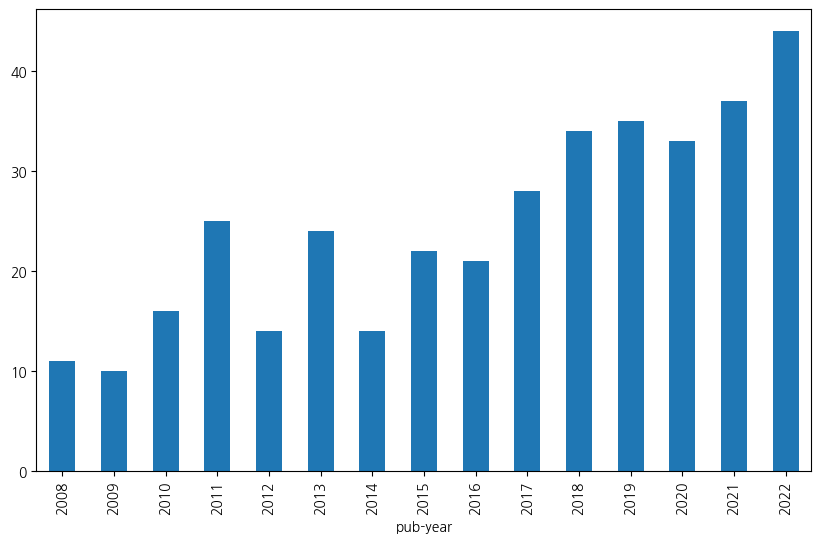

In [40]:
df_park['pub-year'].astype(int).value_counts().sort_index().plot(kind='bar', figsize=(10, 6))

In [43]:
# 한글이 포함된 키워드만 남기기 위한 함수
def filter_korean_keywords(keywords):
    if isinstance(keywords, list):
        return [kw for kw in keywords if re.search(r'\p{Hangul}', kw)]
    return []

# keywords 열에 필터 함수 적용
df_park['keywords'] = df_park['keywords'].progress_apply(lambda x: filter_korean_keywords(x))

  0%|          | 0/368 [00:00<?, ?it/s]

In [57]:
# article-title-original, keywords, abstract-original 열을 결합하는 함수
def concatenate_columns(row):
    keywords_str = ' '.join(row['keywords']) if isinstance(row['keywords'], list) else ''
    return f"{row['article-title-original']} {keywords_str} {row['abstract-original']}"

# 새로운 열 추가
df_park['combined_text'] = df_park.apply(concatenate_columns, axis=1)

# 결과 출력
print(df_park[['article-id', 'combined_text']])

       article-id                                      combined_text
0    ART002536682  박완서의 『오만과 몽상』 연구 -정체성 문제를 중심으로 박완서  『오만과 몽상』  ...
1    ART002537234  국어교육에서 '갈등'을 다루는 방식에 대한 비판적 고찰 - 2015 개정 교육과정에...
2    ART002539904  분단과 민족에 대한 영화적 탐색 - 1980년대 한국 영화를 중심으로 - 분단  민...
3    ART002545671  상생과 불협화음의 경계에 선 말년성(lateness) - 박완서의 「빨갱이 바이러스...
4    ART002539721  이승우 치매 모티프 소설의 이야기 정체성 고찰 (Ⅱ) - <일식에 대하여>, <방>...
..            ...                                                ...
363  ART002359744  박완서의 『목마른 계절』에 나타난 청년들의 전향과 신념의 문제 박완서 『목마른 계절...
364  ART002795263  재미한인 여성수필의 공간과 젠더지리 - ‘차이’와 ‘사이’, ‘탈장소’ 재미한인 여...
365  ART002850409  산업화 시대 소설 문학에 나타난 식(食)의 의미 - 조세희·황석영의 소설을 중심으로...
366  ART001771300  위악적인 어른들의 사회에 대한 대응 과정에서 소년의 성장과 열린사회에의 지향 속악함...
367  ART002073380  해방기 장편 아동서사의 현실인식 연구 해방기 현실인식 아동서사 소년소설 아동문학 광...

[368 rows x 2 columns]


### 토크나이징

In [61]:
def tokenize_part(sent):
    tokens = kiwi.tokenize(sent)
    return [token.form
            for token in tokens
            if token.tag in ['NNG', 'NNP']]  # NNG, NNP, SL 태그를 가진 토큰만 추출

In [63]:
df_park['tokens'] = df_park['combined_text'].progress_map(lambda x:tokenize_part(x))

  0%|          | 0/368 [00:00<?, ?it/s]

In [64]:
df_park['tokens']

0      [박완서, 오만, 몽상, 연구, 정체성, 문제, 중심, 박완서, 오만, 몽상, 정체...
1      [국어, 교육, 갈등, 방식, 비판, 고찰, 개정, 교육, 과정, 중학교, 국어, ...
2      [분단, 민족, 영화, 탐색, 한국, 영화, 중심, 분단, 민족, 한국, 영화, 여...
3      [상생, 불협화음, 경계, 말년, 박완서, 빨갱이, 바이러스, 중심, 박완서, 말년...
4      [이승우, 치매, 모티프, 소설, 이야기, 정체, 고찰, 일식, 방, 중심, 치매,...
                             ...                        
363    [박완서, 계절, 청년, 전향, 신념, 문제, 박완서, 계절, 전향, 이념, 표현,...
364    [재미, 한인, 여성, 수필, 공간, 젠더, 지리, 차이, 사이, 장소, 재미, 한...
365    [산업, 시대, 소설, 문학, 식, 의미, 조세희, 황석영, 소설, 중심, 산업, ...
366    [위악, 어른, 사회, 대응, 과정, 소년, 성장, 열린사회, 지향, 속, 악, 소...
367    [해방, 장편, 아동, 서사, 현실, 인식, 연구, 방기, 현실, 인식, 아동, 서...
Name: tokens, Length: 368, dtype: object

총 Bigram 수: 9
엄마_말뚝: 35
빨갱이_바이러스: 20
날_시작: 20
오만_몽상: 18
워드_프로세서: 15
연애_관: 14
자전거_도둑: 13
박경리_토지: 12
천변_풍경: 11


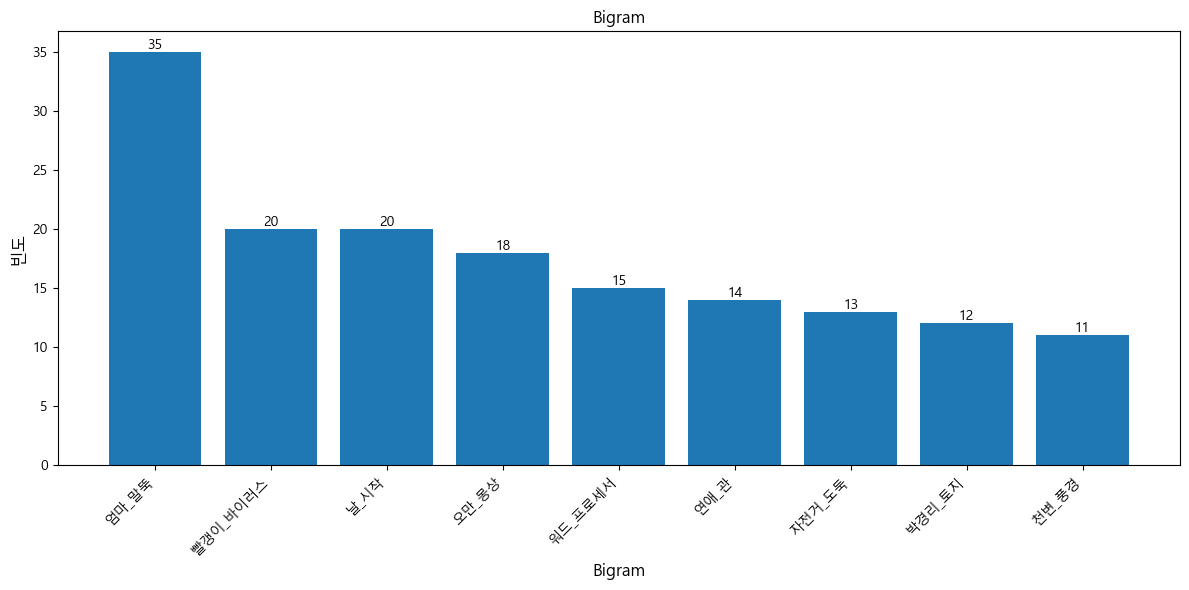

In [75]:
# gensim Phrases 모델 생성
bigram = Phrases(df_park['tokens'], min_count=10, threshold=100)  # min_count와 threshold를 조정하여 결과를 조절할 수 있습니다
bigram_model = Phraser(bigram)

# 바이그램 적용 함수
def apply_bigrams(tokens):
    return bigram_model[tokens]

# 각 행에 바이그램 적용
df_park['bigrams'] = df_park['tokens'].apply(apply_bigrams)

# 모든 바이그램 추출 및 빈도 계산
all_bigrams = [token for tokens in df_park['bigrams'] for token in tokens if '_' in token]
bigram_counts = Counter(all_bigrams)

# 결과 출력
print(f"총 Bigram 수: {len(bigram_counts)}")
# print("\n상위 20개 Bigram:")
for bigram, count in bigram_counts.most_common():
    print(f"{bigram}: {count}")

# 상위 15개 bigram 시각화
top_15 = dict(bigram_counts.most_common(20))

plt.figure(figsize=(12, 6))
bars = plt.bar(top_15.keys(), top_15.values())
plt.title("Bigram", fontproperties=font_prop)
plt.xlabel('Bigram', fontproperties=font_prop)
plt.ylabel('빈도', fontproperties=font_prop)
plt.xticks(rotation=45, ha='right')

# 막대 위에 빈도 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

   Word  Frequency
0     삶        393
1     속        320
2     점        260
3     글        176
4     성        175
5     집        145
6     시        122
7     장        113
8     말         92
9     때         87
10    몸         78
11    일         54
12    힘         49
13    나         48
14    안         48
15    사         48
16    딸         41
17    문         37
18    길         35
19    법         32
20    애         28
21    상         27
22    산         26
23    남         25
24    밖         25
25    후         25
26    공         25
27    유         25
28    학         23
29    위         23
30    혼         23
31    곳         21
32    죄         21
33    부         20
34    틀         20
35    방         19
36    기         19
37    망         19
38    물         18
39    앞         18
40    해         18
41    현         17
42    내         17
43    목         17
44    전         17
45    인         17
46    선         16
47    하         16
48    악         16
49    정         15


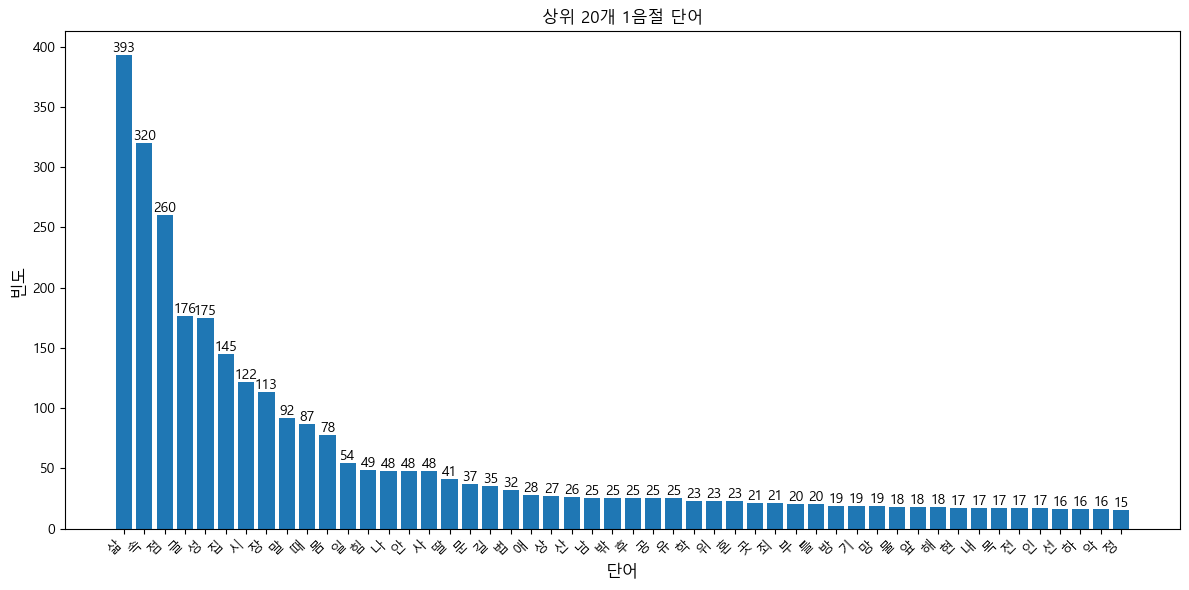

In [77]:
# 1음절 단어 추출 및 빈도 계산 함수
def get_single_syllable_words(tokens_series):
    all_tokens = [token for tokens in tokens_series for token in tokens]
    single_syllable_words = [word for word in all_tokens if len(word) == 1]
    word_counts = Counter(single_syllable_words)
    top_20 = word_counts.most_common(50)
    return top_20

# 실행
top_20_single_syllable = get_single_syllable_words(df_park['bigrams'])

# 결과를 데이터프레임으로 변환
result_df = pd.DataFrame(top_20_single_syllable, columns=['Word', 'Frequency'])

# 결과 출력
print(result_df)

# 막대 그래프로 시각화
plt.figure(figsize=(12, 6))
bars = plt.bar(result_df['Word'], result_df['Frequency'])
plt.title('상위 20개 1음절 단어', fontproperties=font_prop)
plt.xlabel('단어', fontproperties=font_prop)
plt.ylabel('빈도', fontproperties=font_prop)
plt.xticks(rotation=45, ha='right')

# 막대 위에 빈도 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 삶, 집, 시, 말, 몸, 힘, 딸, 길, 법, 남, 여, 선, 악, 죄, 혼, 학 

In [79]:
# 보존할 1음절 단어 리스트
keep_words = ['삶', '집', '시', '말', '몸', '힘', '딸', '길', '법', '남', '여', '선', '악', '죄', '혼', '학']

# 토큰 필터링 함수
def filter_tokens(tokens):
    if isinstance(tokens, pd.Series):
        tokens = tokens.tolist()
    
    return [token for token in tokens if len(token) > 1 or token in keep_words]

# 'bigrams' 컬럼에 필터링 적용 (실제로는 토큰 리스트임)
df_park['filtered_tokens'] = df_park['bigrams'].apply(filter_tokens)

# 결과 확인
print("필터링 전 토큰 수의 평균:", df_park['bigrams'].apply(lambda x: len(x) if isinstance(x, list) else len(x.tolist())).mean())
print("필터링 후 토큰 수의 평균:", df_park['filtered_tokens'].apply(len).mean())

# 제거된 토큰 예시 (처음 5개 행)
print("\n제거된 토큰 예시 (처음 5개 행):")
for i in range(5):
    original = df_park['bigrams'].iloc[i]
    if isinstance(original, pd.Series):
        original = original.tolist()
    removed = set(original) - set(df_park['filtered_tokens'].iloc[i])
    print(f"행 {i}: {list(removed)}")

# 전체 데이터에서 제거된 토큰 집계
from collections import Counter

all_removed_tokens = []
for original, filtered in zip(df_park['bigrams'], df_park['filtered_tokens']):
    if isinstance(original, pd.Series):
        original = original.tolist()
    removed = set(original) - set(filtered)
    all_removed_tokens.extend(removed)

removed_tokens_count = Counter(all_removed_tokens)

print("\n가장 많이 제거된 상위 20개 토큰:")
for token, count in removed_tokens_count.most_common(20):
    print(f"{token}: {count}")

# 제거된 1음절 단어 목록 (keep_words 제외)
removed_single_syllables = set(token for token in removed_tokens_count.keys() if len(token) == 1 and token not in keep_words)

print("\n제거된 1음절 단어 목록 (keep_words 제외):")
print(', '.join(sorted(removed_single_syllables)))

필터링 전 토큰 수의 평균: 159.24184782608697
필터링 후 토큰 수의 평균: 151.4891304347826

제거된 토큰 예시 (처음 5개 행):
행 0: ['대', '현', '속', '끝', '과', '부', '꿈', '점', '산', '상', '글', '덕']
행 1: ['점']
행 2: ['글', '속', '성', '깃']
행 3: ['속', '작']
행 4: ['나', '방', '점', '물']

가장 많이 제거된 상위 20개 토큰:
속: 163
점: 136
글: 105
성: 79
때: 66
장: 50
일: 37
안: 37
사: 31
나: 20
후: 20
애: 20
공: 19
위: 19
곳: 18
틀: 18
앞: 17
부: 16
산: 16
상: 16

제거된 1음절 단어 목록 (keep_words 제외):
가, 간, 감, 강, 개, 검, 겁, 겉, 격, 겹, 경, 곁, 고, 곡, 곰, 곳, 공, 과, 관, 광, 구, 국, 군, 궤, 규, 극, 근, 글, 금, 기, 김, 깃, 꼴, 꽃, 꿈, 끈, 끝, 나, 날, 낫, 내, 넋, 녀, 노, 녹, 논, 눈, 능, 달, 담, 답, 당, 대, 댁, 덕, 도, 돈, 돌, 동, 뒤, 드, 들, 듦, 등, 땀, 땅, 때, 떼, 뜰, 뜻, 라, 례, 록, 론, 륜, 리, 림, 맛, 망, 매, 맥, 메, 면, 명, 모, 목, 몫, 못, 무, 문, 물, 미, 민, 박, 밖, 반, 발, 밤, 밥, 방, 배, 백, 벗, 벽, 변, 별, 병, 복, 본, 봄, 부, 북, 분, 불, 붐, 비, 빌, 빛, 뺨, 뼈, 뿔, 사, 삭, 산, 삿, 상, 새, 색, 생, 서, 설, 섬, 성, 소, 속, 손, 송, 쇠, 수, 숙, 술, 숲, 승, 식, 신, 실, 싹, 씨, 아, 안, 앎, 암, 앞, 애, 앤, 양, 업, 역, 연, 열, 염, 영, 옆, 예, 오, 옥, 올, 외, 욕, 우, 운, 원, 월, 웹, 위, 유, 육, 윤, 으, 은, 을, 의, 이, 인, 일, 임, 잎, 자, 작, 잠, 잡, 잣, 장, 재, 쟁, 적,

In [80]:
# 모든 토큰을 하나의 리스트로 합치기
all_tokens = [token for tokens in df_park['filtered_tokens'] for token in tokens]

# 토큰 빈도수 계산
token_counts = Counter(all_tokens)

# 상위 50개 토큰 출력
print("상위 50개 토큰과 그 빈도수:")
for token, count in token_counts.most_common(50):
    print(f"{token}: {count}")

# 전체 토큰 수와 고유 토큰 수 출력
total_tokens = sum(token_counts.values())
unique_tokens = len(token_counts)
print(f"\n전체 토큰 수: {total_tokens}")
print(f"고유 토큰 수: {unique_tokens}")

# 평균 출현 빈도
average_frequency = total_tokens / unique_tokens
print(f"평균 출현 빈도: {average_frequency:.2f}")

# # 옵션: 특정 단어의 빈도수 확인 함수
# def check_word_frequency(word):
#     frequency = token_counts.get(word, 0)
#     print(f"'{word}'의 빈도수: {frequency}")

# # 사용 예:
# check_word_frequency("만화")
# check_word_frequency("웹툰")

# plt.figure(figsize=(12, 6))
# plt.hist([count for count in token_counts.values() if count < 100], bins=50)
# plt.title("토큰 빈도수 분포 (빈도수 100 미만)")
# plt.xlabel("빈도수")
# plt.ylabel("토큰 수")
# plt.show()

상위 50개 토큰과 그 빈도수:
소설: 1213
여성: 1188
박완서: 786
문학: 726
사회: 491
한국: 455
작가: 443
서사: 423
작품: 418
삶: 393
주체: 386
전쟁: 380
노년: 328
연구: 319
문제: 313
중심: 312
과정: 294
의미: 289
인물: 278
자신: 277
의식: 266
기억: 245
가족: 244
남성: 243
공간: 231
정체: 228
젠더: 226
현실: 211
문화: 195
양상: 190
관계: 187
정치: 186
존재: 183
근대: 183
죽음: 180
가능: 180
인식: 175
욕망: 173
중산: 172
분석: 169
방식: 168
대상: 166
재현: 164
장소: 161
인간: 152
가부장: 152
타자: 151
치매: 151
노인: 147
어머니: 146

전체 토큰 수: 55748
고유 토큰 수: 5268
평균 출현 빈도: 10.58


In [99]:
df_park.to_pickle('./2008_2022_한국현대문학_전체_박완서_토큰화.pkl')

### 빈도수 분석

In [88]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# 시기별 데이터 분할
period_1 = df_park[(df_park['pub-year'] >= 2008) & (df_park['pub-year'] <= 2014)]
period_2 = df_park[(df_park['pub-year'] > 2014) & (df_park['pub-year'] <= 2022)]

# 시기별 단순 빈도수 계산 함수
def calculate_frequency(tokens_list):
    all_tokens = [token for tokens in tokens_list for token in tokens]
    return Counter(all_tokens)

# 시기별 단순 빈도수 계산
freq_period_1 = calculate_frequency(period_1['filtered_tokens'])
freq_period_2 = calculate_frequency(period_2['filtered_tokens'])

# 시기별 TF-IDF 계산 함수
def calculate_tfidf(corpus):
    vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, token_pattern=None)  # token_pattern=None 추가
    tfidf_matrix = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.mean(axis=0).A1
    tfidf_dict = dict(zip(feature_names, tfidf_scores))
    return Counter(tfidf_dict)

# 시기별 TF-IDF 계산
tfidf_period_1 = calculate_tfidf(period_1['filtered_tokens'].tolist())
tfidf_period_2 = calculate_tfidf(period_2['filtered_tokens'].tolist())

# 단순 빈도수와 TF-IDF 값을 데이터프레임으로 변환
freq_df_period_1 = pd.DataFrame(freq_period_1.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
freq_df_period_2 = pd.DataFrame(freq_period_2.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

tfidf_df_period_1 = pd.DataFrame(tfidf_period_1.items(), columns=['Word', 'TF-IDF']).sort_values(by='TF-IDF', ascending=False)
tfidf_df_period_2 = pd.DataFrame(tfidf_period_2.items(), columns=['Word', 'TF-IDF']).sort_values(by='TF-IDF', ascending=False)

# 엑셀로 저장
with pd.ExcelWriter('word_analysis_by_period.xlsx') as writer:
    freq_df_period_1.to_excel(writer, sheet_name='2008-2014_Frequency', index=False)
    tfidf_df_period_1.to_excel(writer, sheet_name='2008-2014_TF-IDF', index=False)
    
    freq_df_period_2.to_excel(writer, sheet_name='2015-2022_Frequency', index=False)
    tfidf_df_period_2.to_excel(writer, sheet_name='2015-2022_TF-IDF', index=False)

print("엑셀 파일이 성공적으로 생성되었습니다.")

엑셀 파일이 성공적으로 생성되었습니다.


In [91]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# 시기별 데이터 분할
period_1 = df_park[(df_park['pub-year'] >= 2008) & (df_park['pub-year'] <= 2014)]
period_2 = df_park[(df_park['pub-year'] > 2014) & (df_park['pub-year'] <= 2022)]

# 시기별 단순 빈도수 계산 함수
def calculate_frequency(tokens_list):
    all_tokens = [token for tokens in tokens_list for token in tokens]
    return Counter(all_tokens)

# 시기별 단순 빈도수 계산
freq_period_1 = calculate_frequency(period_1['filtered_tokens'])
freq_period_2 = calculate_frequency(period_2['filtered_tokens'])

# 시기별 TF-IDF 계산 함수
def calculate_tfidf(corpus):
    vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, token_pattern=None)
    tfidf_matrix = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.mean(axis=0).A1
    tfidf_dict = dict(zip(feature_names, tfidf_scores))
    return Counter(tfidf_dict)

# 시기별 TF-IDF 계산
tfidf_period_1 = calculate_tfidf(period_1['filtered_tokens'].tolist())
tfidf_period_2 = calculate_tfidf(period_2['filtered_tokens'].tolist())

# 상위 50개 단어 선택
top_50_freq_period_1 = freq_period_1.most_common(50)
top_50_freq_period_2 = freq_period_2.most_common(50)

top_50_tfidf_period_1 = tfidf_period_1.most_common(50)
top_50_tfidf_period_2 = tfidf_period_2.most_common(50)

# 데이터프레임 생성
df_top_50 = pd.DataFrame({
    '2008-2014_Top_Frequency_Word': [word for word, freq in top_50_freq_period_1],
    '2008-2014_Frequency': [freq for word, freq in top_50_freq_period_1],
    '2008-2014_Top_TF-IDF_Word': [word for word, tfidf in top_50_tfidf_period_1],
    '2008-2014_TF-IDF': [tfidf for word, tfidf in top_50_tfidf_period_1],
    '2015-2022_Top_Frequency_Word': [word for word, freq in top_50_freq_period_2],
    '2015-2022_Frequency': [freq for word, freq in top_50_freq_period_2],
    '2015-2022_Top_TF-IDF_Word': [word for word, tfidf in top_50_tfidf_period_2],
    '2015-2022_TF-IDF': [tfidf for word, tfidf in top_50_tfidf_period_2],
})

# 엑셀로 저장
df_top_50.to_excel('top_50_word_analysis_by_period.xlsx', sheet_name='Top_50_Words', index=False)

print("엑셀 파일이 성공적으로 생성되었습니다.")

엑셀 파일이 성공적으로 생성되었습니다.


##### 두시기 단어 비교 (TFIDF 활용)

In [92]:
# 표준화 안함
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# 시기별 데이터 분할
period_1 = df_park[(df_park['pub-year'] >= 2008) & (df_park['pub-year'] <= 2014)]
period_2 = df_park[(df_park['pub-year'] > 2014) & (df_park['pub-year'] <= 2022)]

# 시기별 TF-IDF 계산 함수
def calculate_tfidf(corpus):
    vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, token_pattern=None)
    tfidf_matrix = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.mean(axis=0).A1
    tfidf_dict = dict(zip(feature_names, tfidf_scores))
    return tfidf_dict

# 시기별 TF-IDF 계산
tfidf_period_1 = calculate_tfidf(period_1['filtered_tokens'].tolist())
tfidf_period_2 = calculate_tfidf(period_2['filtered_tokens'].tolist())

# TF-IDF 차이 계산
tfidf_diff = {word: tfidf_period_1.get(word, 0) - tfidf_period_2.get(word, 0) for word in set(tfidf_period_1.keys()).union(set(tfidf_period_2.keys()))}

# 상위 특화 단어 추출
top_specialized_words_period_1 = sorted(tfidf_diff.items(), key=lambda x: x[1], reverse=True)[:50]
top_specialized_words_period_2 = sorted(tfidf_diff.items(), key=lambda x: x[1], reverse=False)[:50]

# 결과 출력 또는 저장
print("2008-2014 특화 단어:")
print(top_specialized_words_period_1)

print("\n2015-2022 특화 단어:")
print(top_specialized_words_period_2)


2008-2014 특화 단어:
[('근대', 0.01808104660668626), ('문화', 0.016469598188646954), ('소설', 0.015155747674411933), ('박완서', 0.01423593178594676), ('북한', 0.011628404980457849), ('담론', 0.011317860595489471), ('해석', 0.01117696519453489), ('소녀', 0.01083736038114018), ('꽁트', 0.010752332308817485), ('기억', 0.010636942553502404), ('번역', 0.010483671173596366), ('오빠', 0.010218560345803871), ('농촌', 0.009649453565982652), ('장르', 0.009569619554039017), ('비평', 0.009270069969765649), ('서술', 0.009189291491923116), ('일상', 0.00893477887463131), ('망인', 0.008695327247505762), ('생명', 0.00865348610195043), ('마르그리트 뒤라스', 0.008351796640470832), ('제도', 0.008144697174667382), ('표상', 0.008079679626831327), ('중심', 0.007823231696040128), ('대학', 0.0073671780923347295), ('이데올로기', 0.007260297254062435), ('치유', 0.007257655379105801), ('어른', 0.007181867608138622), ('교육', 0.007075571203839469), ('아파트', 0.006991504360808516), ('유년', 0.006823256412536824), ('도시', 0.006737430044776045), ('자유부인', 0.006544650224823758), ('한류', 0.0064

In [98]:
# 표준화
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# 시기별 데이터 분할
period_1 = df_park[(df_park['pub-year'] >= 2008) & (df_park['pub-year'] <= 2014)]
period_2 = df_park[(df_park['pub-year'] > 2014) & (df_park['pub-year'] <= 2022)]

# 시기별 TF-IDF 계산 함수
def calculate_tfidf(corpus):
    vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, token_pattern=None)
    tfidf_matrix = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.mean(axis=0).A1
    return pd.Series(tfidf_scores, index=feature_names)

# TF-IDF 표준화 함수
def standardize_tfidf(tfidf_series):
    scaler = StandardScaler()
    standardized_values = scaler.fit_transform(tfidf_series.values.reshape(-1, 1)).flatten()
    return pd.Series(standardized_values, index=tfidf_series.index)

# 시기별 TF-IDF 계산 및 표준화
tfidf_period_1 = calculate_tfidf(period_1['filtered_tokens'].tolist())
tfidf_period_2 = calculate_tfidf(period_2['filtered_tokens'].tolist())

tfidf_period_1_std = standardize_tfidf(tfidf_period_1)
tfidf_period_2_std = standardize_tfidf(tfidf_period_2)

# 두 시기의 전체 단어 집합
all_words = set(tfidf_period_1_std.index).union(set(tfidf_period_2_std.index))

# TF-IDF 점수 차이 계산
tfidf_diff = {word: tfidf_period_1_std.get(word, 0) - tfidf_period_2_std.get(word, 0) for word in all_words}

# 시기별 특화 단어 상위 50개 추출
top_50_specialized_period_1 = sorted(tfidf_diff.items(), key=lambda x: x[1], reverse=True)[:50]
top_50_specialized_period_2 = sorted(tfidf_diff.items(), key=lambda x: x[1], reverse=False)[:50]

# 데이터프레임으로 변환하여 비교 시트 생성
df_specialized_comparison = pd.DataFrame({
    '2008-2014_Specialized_Word': [word for word, _ in top_50_specialized_period_1],
    '2008-2014_TF-IDF_Difference': [diff for _, diff in top_50_specialized_period_1],
    '2015-2022_Specialized_Word': [word for word, _ in top_50_specialized_period_2],
    '2015-2022_TF-IDF_Difference': [diff for _, diff in top_50_specialized_period_2]
})

# 엑셀로 저장
with pd.ExcelWriter('specialized_words_by_period.xlsx') as writer:
    df_specialized_comparison.to_excel(writer, sheet_name='Specialized_Comparison', index=False)

print("엑셀 파일이 성공적으로 생성되었습니다.")

엑셀 파일이 성공적으로 생성되었습니다.
